## Calories Prediction

In [1]:
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

In [2]:
train_path = 'C:/Users/Ted/Desktop/research/projects/calorie_prediction/dataset/train.csv'
test_path = 'C:/Users/Ted/Desktop/research/projects/calorie_prediction/dataset/test.csv'

In [3]:
train = pd.read_csv(train_path)
test = pd.read_csv(test_path)

In [4]:
train.shape, test.shape

((7500, 11), (7500, 10))

## EDA

##### 학습 데이터 중복 확인

In [5]:
train.duplicated().sum()

0

###### 데이터 중복값 없음

##### 데이터 결측치 및 타입 확인

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ID                        7500 non-null   object 
 1   Exercise_Duration         7500 non-null   float64
 2   Body_Temperature(F)       7500 non-null   float64
 3   BPM                       7500 non-null   float64
 4   Height(Feet)              7500 non-null   float64
 5   Height(Remainder_Inches)  7500 non-null   float64
 6   Weight(lb)                7500 non-null   float64
 7   Weight_Status             7500 non-null   object 
 8   Gender                    7500 non-null   object 
 9   Age                       7500 non-null   int64  
 10  Calories_Burned           7500 non-null   float64
dtypes: float64(7), int64(1), object(3)
memory usage: 644.7+ KB


In [7]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ID                        7500 non-null   object 
 1   Exercise_Duration         7500 non-null   float64
 2   Body_Temperature(F)       7500 non-null   float64
 3   BPM                       7500 non-null   float64
 4   Height(Feet)              7500 non-null   float64
 5   Height(Remainder_Inches)  7500 non-null   float64
 6   Weight(lb)                7500 non-null   float64
 7   Weight_Status             7500 non-null   object 
 8   Gender                    7500 non-null   object 
 9   Age                       7500 non-null   int64  
dtypes: float64(6), int64(1), object(3)
memory usage: 586.1+ KB


###### 데이터 결측치 없음

##### 특성공학
###### Height(Feet) 와 Height(Remainder_Incses) 를 이용하여 Height(cm) 컬럼 생성
###### ℉ 화씨 온도를 ℃ 섭씨 온도로 변환한 Body_Temperature(C) 컬럼 생성
###### lb(파운드) 를 kg 으로 변환한 Weight(kg) 컬럼 생성
###### 학습과 분석에 불필요한 컬럼들 삭제

In [8]:
def feature_engineering(df):
    df['Height(cm)']=df['Height(Feet)']*30.48 + df['Height(Remainder_Inches)']*2.54

    df['Body_Temperature(C)']=(df['Body_Temperature(F)']-32)*5/9

    df['Weight(kg)']=(df['Weight(lb)']*0.45359237)

    df.drop(['ID','Body_Temperature(F)', 'Height(Feet)', 'Height(Remainder_Inches)', 'Weight(lb)'], axis=1, inplace=True)

##### feature_engineering(df) 함수 실행

In [9]:
feature_engineering(train)
feature_engineering(test)

###### 데이터 확인

In [10]:
train

,Exercise_Duration,BPM,Weight_Status,Gender,Age,Calories_Burned,Height(cm),Body_Temperature(C),Weight(kg)
0,26.0,107.0,Normal Weight,F,45,166.0,175.26,40.888889,69.989303
1,7.0,88.0,Overweight,M,50,33.0,198.12,39.611111,102.012924
2,7.0,86.0,Overweight,M,29,23.0,190.50,39.611111,99.019214
3,17.0,99.0,Normal Weight,F,33,91.0,167.64,40.000000,66.995593
4,9.0,88.0,Normal Weight,M,38,32.0,177.80,39.277778,77.019984
...,...,...,...,...,...,...,...,...,...
7495,22.0,104.0,Normal Weight,F,75,151.0,147.32,40.611111,50.983782
7496,20.0,104.0,Normal Weight,F,21,114.0,172.72,40.722222,66.995593
7497,8.0,90.0,Overweight,M,57,41.0,187.96,39.500000,91.988533
7498,12.0,97.0,Overweight,M,35,57.0,175.26,40.222222,76.022081


###### 온도 데이터가 높아보여 온도 데이터 통계 확인

In [11]:
train['Body_Temperature(C)'].describe()

count    7500.000000
mean       40.018652
std         0.784914
min        37.111111
25%        39.611111
50%        40.222222
75%        40.611111
max        41.500000
Name: Body_Temperature(C), dtype: float64

###### 100개 데이터만을 활용하여 분포 확인

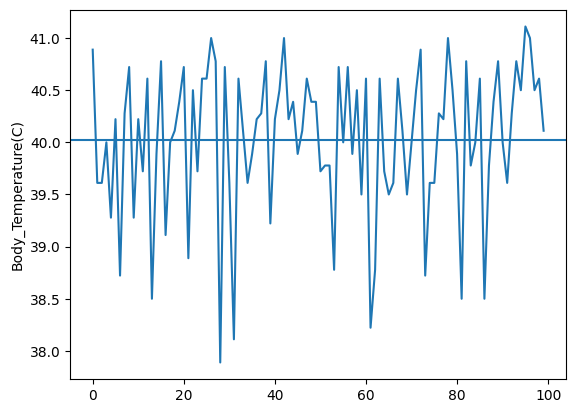

In [12]:
plt.plot(train['Body_Temperature(C)'][:100])
plt.axhline(train['Body_Temperature(C)'].mean())
plt.ylabel('Body_Temperature(C)')
plt.show()

###### 알고있는 도메인 지식으로는 운동시에도 체온조절이 이루어지기 때문에 체온이 38도를 넘는 경우를 찾아보기 어렵다. 이에 대해서 토크 게시판에 다른 참가자가 질문을 남겼으나, 데이터 상에 문제가 없다는 답변을 얻어 별다른 처리 없이 진행을 하였다

##### 이상치 확인

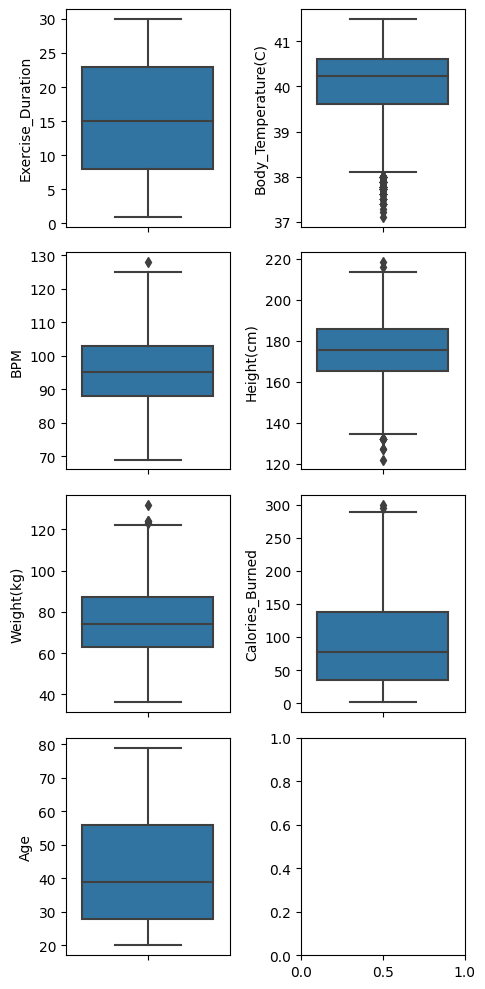

In [13]:
fig, axes = plt.subplots(4,2, figsize = (5,10))

sns.boxplot(y = train['Exercise_Duration'], ax = axes[0][0])
sns.boxplot(y = train['Body_Temperature(C)'], ax = axes[0][1])

sns.boxplot(y = train['BPM'], ax = axes[1][0])
sns.boxplot(y = train['Height(cm)'], ax = axes[1][1])

sns.boxplot(y = train['Weight(kg)'], ax = axes[2][0])
sns.boxplot(y = train['Calories_Burned'], ax = axes[2][1])

sns.boxplot(y = train['Age'], ax = axes[3][0])

plt.tight_layout()
plt.show()

In [14]:
# Height(cm)가 135 미만 215 초과인 데이터 갯수 확인
len(train[train['Height(cm)']<135]), len(train[train['Height(cm)']>215])

(12, 2)

In [15]:
# Weight(kg)이 120 초과인 데이터 갯수 확인
len(train[train['Weight(kg)']>120])

8

In [16]:
# Body_Temperature(C)가 38 밑인 데이터 갯수 확인
len(train[train['Body_Temperature(C)']<38])

143

In [17]:
# BPM이 125 이상인 데이터 갯수 확인
len(train[train['BPM'] > 125])

1

###### 이상치 수가 많지 않아 따로 삭제하지 않기로 결정

##### 히트맵을 통한 상관분석

<Axes: title={'center': 'Calories Correlation of features'}>

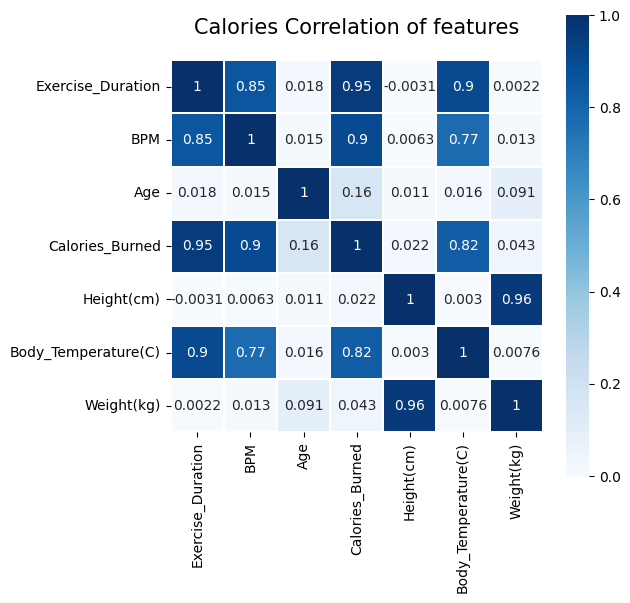

In [18]:
plt.figure(figsize=(6,6))
plt.title("Calories Correlation of features", y=1.05, size=15)
sns.heatmap(train.drop(columns=['Weight_Status', 'Gender']).corr(), linewidths=0.1, vmax=1.0, square=True, cmap="Blues", linecolor="white", annot=True)

###### 'Body_Temperature(C)', 'Exercise_Duration', 'BPM' 이 세 컬럼이 타겟 컬럼인 'Calories_Burned' 컬럼과의 상관계수가 0.8 이상을 보이고 나머지 컬럼들은 0에 가깝게 나타났다.

##### 타겟데이터의 확률밀도분포 확인

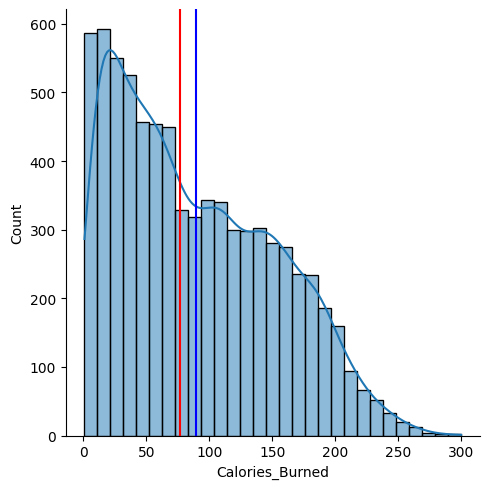

In [19]:
# 타겟 데이터의 확률밀도함수 확인
sns.displot(train['Calories_Burned'], kde=True)

# 평균과, 중앙값으로 수직선 생성
plt.axvline(train['Calories_Burned'].mean(), color='blue')
plt.axvline(train['Calories_Burned'].median(), color='red');

###### 타겟데이터의 분포가 right_skewed 되어있음

##### 나머지 숫자형 데이터의 분포 확인

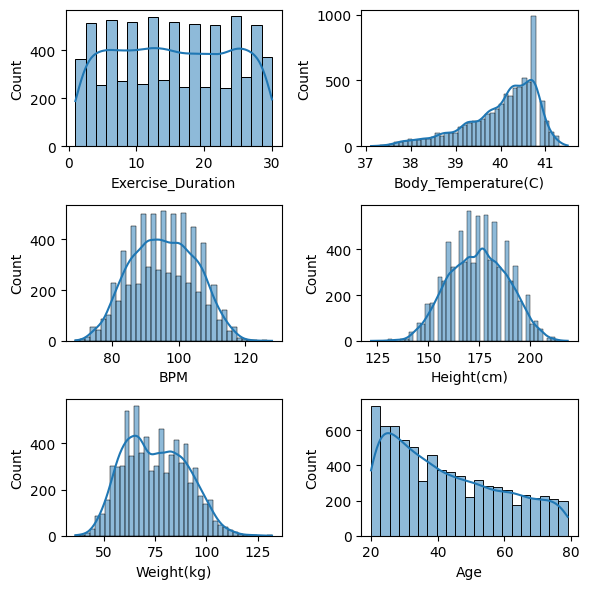

In [25]:
# 나머지 학습에 사용할 컬럼들의 skewed도 확인
fig, axes = plt.subplots(3, 2, figsize = (6, 6))

sns.histplot(train['Exercise_Duration'], kde=True, ax = axes[0][0])
sns.histplot(train['Body_Temperature(C)'], kde=True,ax = axes[0][1])

sns.histplot(train['BPM'], kde=True, ax = axes[1][0])
sns.histplot(train['Height(cm)'], kde=True, ax = axes[1][1])

sns.histplot(train['Weight(kg)'], kde=True, ax = axes[2][0])
sns.histplot(train['Age'], kde=True, ax = axes[2][1])

plt.tight_layout()
plt.show()

### 데이터 전처리
###### 카테고리컬 데이터 인코딩
###### PolynomialFeatures 를 사용하여 다항식 특성 추가
###### StandardScaler 를 사용하여 수치형 데이터의 스케일을 통일

In [8]:
# 'Weight_Status', 'Gender'컬럼 인코딩
from sklearn.preprocessing import LabelEncoder

###### categorical features 선언

In [9]:
categorical_features = ['Weight_Status', 'Gender']
numerical_features = ['Exercise_Duration', 'BPM', 'Age', 'Height(cm)', 'Body_Temperature(C)','Weight(kg)']

###### Labelencoder

In [10]:
def preprocessing(train, test):
    for feature in categorical_features:
        le = LabelEncoder()
        le = le.fit(train[feature])
        train[feature] = le.transform(train[feature])
        for label in np.unique(test[feature]):
            if label not in le.classes_:
                le.classes_ = np.append(le.classes_, label)
        test[feature] = le.transform(test[feature])

In [11]:
preprocessing(train, test)

In [12]:
# 타겟 데이터
train_target = train['Calories_Burned']

###### 학습 데이터에서 타겟 컬럼 제거

In [13]:
train = train.drop(columns='Calories_Burned')

###### PolynomialFeatures와 StandardScaler를 사용한 학습 및 테스트 데이터 변환

In [14]:
poly = PolynomialFeatures(degree=2, include_bias=False)
ss = StandardScaler()

train_poly = ss.fit_transform(train)
test_poly = ss.transform(test)
train_poly = poly.fit_transform(train_poly)
test_poly = poly.transform(test_poly)

### 모델 학습 및 검정

In [15]:
# 데이터셋 분리
from sklearn.model_selection import train_test_split

train_X, val_X, train_Y, val_Y = train_test_split(train_poly, train_target, test_size=0.30, random_state=42)

###### 사용가능 gpu 확인

In [17]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 1250690594816573992
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 2910958388
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 9861357636048788966
 physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 970, pci bus id: 0000:07:00.0, compute capability: 5.2"
 xla_global_id: 416903419]

In [22]:
print(tf.test.is_gpu_available())

True


###### 시드 고정

In [24]:
tf.random.set_seed(42)

###### 모델 학습

In [25]:
from sklearn.model_selection import GridSearchCV, KFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor


def create_model(hidden_layers=1, neurons=64, dropout_rate=0.0, lr=0.001):
    model = Sequential()
    for i in range(hidden_layers):
        if i == 0:
            model.add(Dense(neurons, input_dim=train_X.shape[1], activation='relu'))
        else:
            model.add(Dense(neurons, activation='relu'))
        if dropout_rate > 0.0:
            model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(lr=lr))
    return model

# Create a KerasRegressor
model = KerasRegressor(build_fn=create_model, epochs=100, batch_size=32, verbose=0)

# Define the grid search parameters
param_grid = {
    'hidden_layers': [1, 2, 3],
    'neurons': [32, 64, 128, 256],
    'dropout_rate': [0.0, 0.1, 0.2, 0.3],
    'lr': [0.001, 0.01, 0.1]
}

# Perform a grid search with cross-validation
with tf.device('/GPU:0'):
    grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=KFold(n_splits=5))
    grid_result = grid.fit(train_X, train_Y)

# Print the best results
print(f"Best score: {-grid_result.best_score_:.2f} using {grid_result.best_params_}")

C:\Users\Ted\AppData\Local\Temp\ipykernel_7928\4258024202.py:21: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_model, epochs=100, batch_size=32, verbose=0)


Best score: 0.32 using {'dropout_rate': 0.0, 'hidden_layers': 1, 'lr': 0.001, 'neurons': 256}


In [26]:
# Get the best model
best_model = grid_result.best_estimator_

# Train the best model
best_model.fit(train_X, train_Y)

###### 검증세트를 이용한 예측 및 rmse 확인

In [27]:
y_pred = best_model.predict(val_X)

In [28]:
rmse = np.sqrt(mean_squared_error(val_Y, y_pred))

In [30]:
rmse

0.480516450185481

###### 테스트 세트를 이용한 데이터 예측 및 예측 값 저장

In [31]:
y_pred_test = best_model.predict(test_poly)

In [32]:
y_pred_test

array([172.82155 , 189.43541 ,  53.52697 , ..., 130.35858 ,  32.254997,
       191.17355 ], dtype=float32)

In [35]:
sample_submission = pd.read_csv('C:/Users/Ted/Desktop/research/projects/calorie_prediction/dataset/sample_submission.csv')

In [23]:
sample_submission['Calories_Burned'] = y_pred_test
sample_submission.to_csv('submission_tf_gpu_gridcv.csv', index=False)